# UR Desa Sentinel 10m ES

Kode modelling klasifikasi densenet dan resnet urban rural pada data sentinel 2 10m dengan neighbor Square, input tingkat desa.

## Import Fast AI

In [2]:
import fastai
from fastai.vision.all import *
import pandas as pd

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

In [4]:
torch.cuda.empty_cache() 

Buka variabel dataset urban rural

In [4]:
sls = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/3200_sls.csv")

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
sls.head()

,id,kdprov,kdkab,kdkec,kddesa,iddesa,idslsnon,nmslsnon,ketua_sls,jenis,...,j_bstt,j_bsbtt,j_bstt_k,j_bskeko,j_segmen,dom,ldom,j_m_all,j_m_30,klas_ur
0,263884,32,1,10,1,3201010001,100,RT 001 RW 001 DUSUN 1,MUHAMAD RAFLI HIDAYAT,1,...,39,1,2,4,1,1,1,51,51,2
1,263885,32,1,10,1,3201010001,200,RT 002 RW 001 DUSUN 1,NURMAN,1,...,60,2,0,7,1,1,1,62,61,2
2,263886,32,1,10,1,3201010001,300,RT 003 RW 001 DUSUN 1,SAENUDIN,1,...,50,2,0,6,1,1,1,58,57,2
3,263887,32,1,10,1,3201010001,400,RT 004 RW 001 DUSUN 1,AEP,1,...,27,1,0,1,1,1,1,31,31,2
4,263888,32,1,10,1,3201010001,500,RT 005 RW 001 DUSUN 1,JEJEN JAELANI,1,...,49,7,3,8,3,1,1,63,57,2


In [6]:
sls.iddesa.unique().shape

(5957,)

Alokasi citra square neighbor desa ke folder sesuai dengan input fast ai

In [9]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/jabartruecrop/"
from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        try :
            if(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 1):
                shutil.copy(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar10m_ur_truecrop/urban/"+name)
            elif(sls.klas_ur[sls.iddesa == int(name.replace(".jpg","")[:10])].iloc[0] == 2):
                shutil.copy(os.path.join(root, name), "C:/Users/jwst2/Python/tesis/jpg/jabar10m_ur_truecrop/rural/"+name)
        except Exception:
            print(name)
            pass 

0it [00:00, ?it/s]

3207000000.jpg
3208000000.jpg
3208010000.jpg
3211080000.jpg
3211111000.jpg
3217000000.jpg


1it [00:22, 22.61s/it]


### Preprocessing input image

In [5]:
path = Path.cwd() / ("C:/Users/jwst2/Python/tesis/jpg/UR/03. Sentinel 10M Desa ES/")

In [6]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('rural'),Path('urban')]

In [7]:
fname = (path/"rural").ls()[0]
fname

Path('rural/3201010001.jpg')

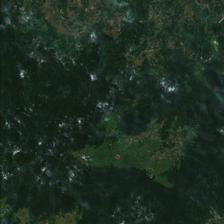

In [8]:
img = Image.open(fname)
img

In [9]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(valid_pct=0.1, seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label, # extracts the label category from the image's folder name 
                 batch_tfms=aug_transforms(mult=2)) # data augmentation (mult multiplies the default transformation values)

In [10]:
dls = blocks.dataloaders(path,bs=4)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


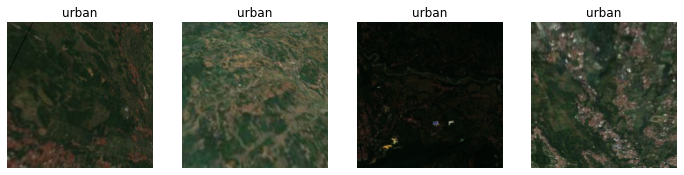

In [11]:
dls.show_batch(nrows=1)

In [ ]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s, roca]
learn = cnn_learner(dls, densenet121, metrics=metrics) 
learn.summary()

## Densenet

Pemodelan dengan densenet121

C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\fastai\callback\schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.007585775572806597)

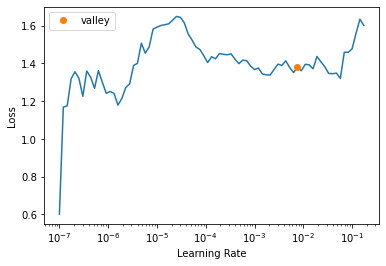

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(15,1e-2)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.889730,0.531112,0.764706,0.722336,0.712190,0.722336,0.716667,0.821638,04:20
1,0.682303,0.541180,0.751261,0.684085,0.691257,0.684085,0.687358,0.800059,04:03
2,0.569486,0.619918,0.724370,0.529957,0.656816,0.529957,0.490752,0.673218,04:04
3,0.519304,0.487272,0.766387,0.732533,0.716176,0.732533,0.722773,0.819463,04:04
4,0.476762,0.406785,0.794958,0.781323,0.751841,0.781323,0.762143,0.874275,04:07
5,0.518866,0.446227,0.800000,0.671107,0.807740,0.671107,0.694180,0.861478,04:11
6,0.497724,0.383293,0.826891,0.740388,0.808345,0.740388,0.762392,0.883489,04:13
7,0.472535,0.400835,0.806723,0.681206,0.818884,0.681206,0.706231,0.895910,04:15
8,0.503486,0.389842,0.800000,0.678327,0.795098,0.678327,0.701322,0.897597,04:15
9,0.448020,0.360016,0.838655,0.781079,0.807586,0.781079,0.792339,0.897736,04:15


Ekspor model

In [21]:
learn.export('C:/Users/jwst2/Python/tesis/models/18042022 D010.pkl')

In [22]:
from sklearn.metrics import confusion_matrix

### Resnet

Pemodelan dengan resnet

In [13]:
learn_rs = cnn_learner(dls, resnet50, metrics=metrics) 

SuggestedLRs(valley=0.00010964782268274575)

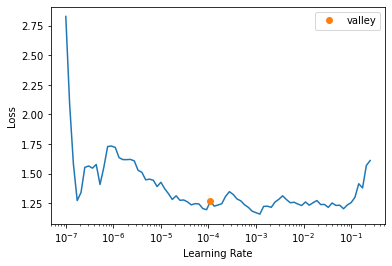

In [15]:
learn_rs.lr_find()

In [25]:
learn_rs.fit_one_cycle(15,1e-3)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.927121,0.552829,0.742857,0.656567,0.677198,0.656567,0.664178,0.771858,02:36
1,0.594007,0.532597,0.747899,0.750342,0.711965,0.750342,0.718937,0.832162,02:36
2,0.548910,0.422858,0.794958,0.707309,0.754632,0.707309,0.723167,0.852891,02:34
3,0.571090,0.446127,0.731092,0.574356,0.656956,0.574356,0.571665,0.830267,02:36
4,0.581218,0.410477,0.800000,0.694575,0.775436,0.694575,0.715699,0.869145,02:35
5,0.526017,0.372086,0.820168,0.762783,0.781174,0.762783,0.770865,0.889846,02:33
6,0.517975,0.442670,0.714286,0.499463,0.483714,0.499463,0.422317,0.872463,02:32
7,0.477707,0.375756,0.825210,0.735607,0.808230,0.735607,0.758334,0.887156,02:34
8,0.540839,0.390930,0.821849,0.717018,0.819632,0.717018,0.743393,0.888898,02:34
9,0.504190,0.446768,0.752941,0.567916,0.817684,0.567916,0.549208,0.893108,02:32


In [32]:
learn_rs.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.445440,0.368221,0.836975,0.754635,0.822479,0.754635,0.777301,0.900050,03:23


In [31]:
learn_rs.export('C:/Users/jwst2/Python/tesis/models/18042022 R010.pkl')